# DVL Navigation and State Estimation

1. [Import Libraries](#import-libraries)
    1. [Glider Flight Computer Data](#import-glider-flight-computer)
    1. [Bathymetry Data](#import-bathymetry)
    1. [DVL Data](#import-dvl-data)
    1. [Select Time Series](#import-select-time-series)
1. [Load and Parse Data](#load-and-parse-data)
1. [Compute Water Column Currents](#compute-water-column-currents)
1. [Compute DVL-Odometry](#compute-dvl-odometry)
1. [Multi-Factor Terrain Aided Navigation](#multi-factor-terrain-aided-navigation)
1. [Sandbox](#sandbox)
1. [Unit Testing](#unit-testing)


---
<a id='import-libraries'></a>
## Import Libraries

In [16]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import scipy.signal
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for parsing raw DVL data 
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries

# objects for estimating ocean current velocities
import VelocityShearPropagation

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

# objects for parsing flight and science computer log files
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
import BathymetryMap

# data for parsing seafloor bathymetry
import bathy_meta_data
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(VelocityShearPropagation)
    importlib.reload(AdaptiveVelocityController)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)
    importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)

---
<a id='load-and-parse-data'></a>
## Load and/or Parse Data
<a id='import-glider-flight-computer'></a>
### A. Glider Flight Computer Data

In [2]:
reload_modules()
directory = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/"
ts_flight_kolumbo_all = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


---
<a id='import-bathymetry'></a>
### B. Seafloor Bathymetry Data

In [3]:
reload_modules()
# meta_dict = bathy_meta_data.BathyData["Kolumbo_full"]
meta_dict = bathy_meta_data.BathyData["Kolumbo"]
bathy     = BathymetryMap.BathymetryMap(meta_dict=meta_dict)
bathy.parse_bathy_file()

In [5]:
bathy_df = pd.read_csv('/Users/zduguid/Desktop/dat/Kolumbo-10m-sub.csv')

---
<a id='import-dvl-data'></a>
### C. DVL data 

In [253]:
reload_modules()
glider = "sentinel"
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)

#################################################
# File ID Number ################################
#################################################
filename2  = "sk211652.pd0" # DIVE 2
filename3  = "01820002.pd0" # DIVE 3
filename4  = "sk220034.pd0" # DIVE 4
filename5  = "01820008.pd0" # DIVE 5
filename7  = "01820013.pd0" # DIVE 7
filename9  = "sk222256.pd0" # DIVE 9
filename12 = "sk230350.pd0" # DIVE 12
filename14 = "sk261222.pd0" # DIVE 14

#################################################
# Parse Selected File IDs #######################
#################################################
ts2  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename2,  save=False)
ts3  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename3,  save=False)
ts4  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename4,  save=False)
ts5  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename5,  save=False)
ts7  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename7,  save=False)
ts9  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename9,  save=False)
ts12 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename12, save=False)
ts14 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename14, save=False)

#################################################
# Frontiers (and Thesis) Naming Convention ######
#################################################
tsa  = ts14
tsb  = ts12
tsc  = ts2
tsd  = ts3
tse  = ts4
tsf  = ts5
tsg  = ts7 # (not included in Frontiers)
tsh  = ts9 # (not included in Frontiers)

#################################################
# JFR Naming Convention #########################
#################################################
# tsa  = ts14
# tsb  = ts5
# tsc  = ts4
# tsd  = ts3
# tse  = ts7

________________________________________
- Parsing DVL File ---------------------
    input file: sk211652.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
    # ensembles:   2600
    # ensembles:   2800
    # ensembles:   3000
    # ensembles:   3200
    # ensembles:   3400
- Parsing Complete ---------------------
    # ensembles:   3442
    parsing time:  12.029462
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords
________________________________________
- Parsing DVL File ---------------------
    input file: 01820

---
<a id='import-select-time-series'></a>
### D. Select Time Series 

In [479]:
ts = tsb

---
<a id='compute-water-column-currents'></a>
## Compute Water Column Currents 

In [480]:
reload_modules()

# tuning parameters for working with DVL data 
pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
start_filter         =  2    # [bin #] avoid using the first number of bins
end_filter           =  2    # [bin #] avoid using the last number of bins 
voc_mag_filter       =  1.0  # [m/s]   filter out ocean current 
voc_delta_mag_filter =  0.5  # [m/s]   filter out deltas between layers
near_surface_filter  = 10    # [m]     ignore Vtw when near surface 

# constants
DEG_TO_RAD = np.pi/180

# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
max_range    = 80
max_depth    = int(np.max(ts.df.depth)+80)
x_beam       = 0
y_beam       = 1

# intialize water column
water_column = VelocityShearPropagation.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    pitch = ts.df.pitch[t]
    roll  = ts.df.roll[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # extract Voc reference from bottom track velocity when available
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_u = ts.df.abs_vel_btm_u[t]
        vog_v = ts.df.abs_vel_btm_v[t]
        voc_u = vog_u - vtw_u
        voc_v = vog_v - vtw_v
        voc_ref = VelocityShearPropagation.OceanCurrent(voc_u, voc_v, 0)
    else:
        voc_ref = VelocityShearPropagation.OceanCurrent()
        
    # add shear nodes for each DVL depth bin that meet the filter criteria
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    if num_good_vel_bins > start_filter+end_filter:        
        
        # determine if glider ascending or descending
        delta_z = ts.df.delta_z[t]
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        # build list of velocity shears to add as ShearNode to water column
        delta_voc_u = []
        delta_voc_v = []

        # add all valid DVL bins to the shear list 
        #   + filtering of DVL bins will occur in the `add_shear_node` call
        for bin_num in range(int(num_good_vel_bins)):

            # retrieve the shear list from the DVL data 
            x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
            y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
            dvl_x = ts.df[x_var][t]
            dvl_y = ts.df[y_var][t]

            # compute delta between dead-reckoned through-water velocity & DVL
            delta_voc_u.append(vtw_u - (-dvl_x))
            delta_voc_v.append(vtw_v - (-dvl_y))

        shear_list = [VelocityShearPropagation.OceanCurrent(
                        delta_voc_u[i], 
                        delta_voc_v[i], 
                        0) 
                      for i in range(len(delta_voc_u))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction,
                pitch=pitch,
                roll=roll,
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction,
            pitch=pitch,
            roll=roll,
        )
        
voc_u_list,voc_v_list,voc_w_list,voc_z_list = water_column.compute_averages()
print("> Finished Estimating Water Column Currents!")
# print(water_column.averages_to_str())

> Finished Estimating Water Column Currents!


---
<a id='compute-dvl-odometry'></a>
## Compute DVL-Odometry

In [481]:
# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]

# set flag for setting GPS updates
flag_gps_fix_at_surface = False 

# extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x = df_dbd.m_x_lmc[t]
        dbd_origin_y = df_dbd.m_y_lmc[t]
        break

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.time[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]
    
    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        flag_gps_fix_at_surface = False
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
    
    # retrieve ocean current estimate from water column 
    voc_u = voc_u_list[int(depth)]
    voc_v = voc_v_list[int(depth)]

    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        
    # CASE 2: use through water velocity and ocean current estimate if available
    elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t

    # CASE 3: use through water velocity if available
    elif (not np.isnan(vtw_u)):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t

    # CASE 4: use ocean current estimate if available
    elif (not np.isnan(voc_u)):
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                flag_gps_fix_at_surface = True
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)

# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


---
<a id='multi-factor-terrain-aided-navigation'></a>
## Multi-Factor Terrain Aided Navigation (MF-TAN)
- Filter out when glider is inflecting due to inaccuracies that are introduced
- Filter out when altitude is too low (avoid the points during "smear")
- Filter out when too long of gap between time points
- Consider multiple ensemble points when estimating three-factors 
    - right now, four measurements from the same ensemble are being used to compute factors
    - instead, multiple sequential ensembles can be collected and then run least squares on a group of points
    - idea: match or exceed the size of grid spacing (10m) with DVL points (don't want to oversample)
    - research question: what level of averaging leads to the best results?
- Normally TAN methods require constant bottom-lock to function properly -- our approach can help to solve the "hidden-robot" problem by introducing more features 
    - assume 20-30% error of distance traveled when using DVL-Odo, then bring down uncertainty when navigation fix is made
    - these ideas motivate the idea of active localization 

In [248]:
# Urgent TODOs
# - use multiple ensembles to extract factors, evaluate stability, make 3D plot with bathy below and factors extracted
# - plot area of map that meets each factor threshold, then show overlap of factors (localization!)
# - draft abstract (200 words)
# - send Chap1, Chap2, Chap5 and Abstract to Rich

# Upcoming TODOs 
# - implement particle filter 
# - implement sea-ice classfication scheme


In [251]:
JANUS_ANGLE = 30
DEG_TO_RAD  = np.pi/180
sin_janus   = np.sin(JANUS_ANGLE*DEG_TO_RAD)
cos_janus   = np.cos(JANUS_ANGLE*DEG_TO_RAD)
min_valid_slant_ranges = 3 

beam_heading_offsets = {
    0 : -90,
    1 :  90,
    2 :   0,
    3 : 180 
}


# collect set of bottom track point
class PointCloud(object):
    def __init__(self):
        """TODO"""
        self.set        = set([])
        self.first_time = np.nan
        self.last_time  = np.nan
        self.min_x      = np.nan
        self.min_y      = np.nan
    
    def add_point(bt_point):
        pass

    
class BottomTrackPoint(object):
    def __init__(self, time_index, beam_num, instrument_x, instrument_y, instrument_z, aug_x, aug_y, aug_z): 
        """TODO
        Coordinate system:
            (+) x = East 
            (+) y = North 
            (+) z = Upwards (away from the center of the Earth)
        """
        self.time_index   = time_index
        self.beam_num     = beam_num
        self.instrument_x = instrument_x
        self.instrument_y = instrument_y
        self.instrument_z = instrument_z
        self.aug_x        = aug_x
        self.aug_y        = aug_y
        self.aug_z        = aug_z
        self.earth_x      = instrument_x + aug_x
        self.earth_y      = instrument_y + aug_y
        self.earth_z      = instrument_z + aug_z
        
    
    def __str__(self):
        """TODO"""
        def num_to_str(num):
            if   num  < 0 and abs(num) < 10: space = ' '
            elif num  < 0 and abs(num) > 10: space = ''
            elif num >= 0 and abs(num) < 10: space = '  '
            elif num >= 0 and abs(num) > 10: space = ' '
            return("%s%.2f" % (space, num))
        
        return('Beam%d' % self.beam_num   + 
               '<%4d, ' % self.time_index + 
               '%s, %s, %s>' % tuple([num_to_str(num) for num in [self.instrument_x, 
                                                                  self.instrument_y, 
                                                                  self.instrument_z]]))
    def x(self): 
        return(self.earth_x)
    
    def y(self): 
        return(self.earth_y)
    
    def z(self): 
        return(self.earth_z)
    
    def get_xyz(self):
        return(np.array([[self.x], [self.y], [self.z]]))
        

def Qx(phi):
    """Orthogonal rotation matrix about x-axis by angle phi
    """
    return(np.array([[           1,            0,            0],
                     [           0,  np.cos(phi), -np.sin(phi)],
                     [           0,  np.sin(phi),  np.cos(phi)]]))


def Qy(phi):
    """Orthogonal rotation matrix about y-axis by angle phi
    """
    return(np.array([[ np.cos(phi),            0,  np.sin(phi)],
                     [           0,            1,            0],
                     [-np.sin(phi),            0,  np.cos(phi)]]))


def Qz(phi):
    """Orthogonal rotation matrix about z-axis by angle phi
    """
    return(np.array([[ np.cos(phi), -np.sin(phi),            0],
                     [ np.sin(phi),  np.cos(phi),            0],
                     [           0,            0,            1]]))


# for t in range(len(ts.df)):
for t in range(1000):
    
    # extract slant ranges 
    slant_ranges = {
        0 : ts.df.btm_beam0_range[t] / cos_janus,
        1 : ts.df.btm_beam1_range[t] / cos_janus,
        2 : ts.df.btm_beam2_range[t] / cos_janus,
        3 : ts.df.btm_beam3_range[t] / cos_janus,
    }

    # ignore case when less than three ranges are available
    valid_slant_ranges = {key:slant_ranges[key] for key in 
        slant_ranges.keys() if not np.isnan(slant_ranges[key])}
    
    # extract current AUV position in LMC coordinates
    aug_x = ts.df.rel_pos_x[t]
    aug_y = ts.df.rel_pos_y[t]
    aug_z = ts.df.rel_pos_z[t]
    aug_z *= -1 
    aug_heading = ts.df.heading[t]

    # ignore case when 3 or less slant ranges are present
    if len(valid_slant_ranges) < min_valid_slant_ranges:
        continue

    # extract bottom contact positions in Earth coordinate frame
    point_cloud = []
    for beam in valid_slant_ranges:
        r = valid_slant_ranges[beam]
        z = r*cos_janus  # vertical component 
        h = r*sin_janus  # horizontal component
        
        # extract beam angle in Earth frame
        beam_heading = aug_heading + beam_heading_offsets[beam]
        x = h*np.sin(beam_heading*DEG_TO_RAD)
        y = h*np.cos(beam_heading*DEG_TO_RAD)
        
        # add to the point cloud
        point_cloud.append(BottomTrackPoint(t, beam, x, y, -z, aug_x, aug_y, aug_z))
        
    for point in point_cloud:
        print(point)
    print()
    
#     # rotate instrument coordinates into the world frame using Euler angles
#     earth_coords = []
#     Qx = self.Qx((self.pitch   + self.BIAS_PITCH)   * self.DEG_TO_RAD)
#     Qy = self.Qy((self.roll    + self.BIAS_ROLL)    * self.DEG_TO_RAD)
#     Qz = self.Qz((self.heading + self.BIAS_HEADING) * self.DEG_TO_RAD)
#     for pos in inst_coords:
#         earth_coords.append(np.dot(Qz, np.dot(Qy, np.dot(Qx, pos))))

#     # use least squares approach to find planar surface of best fit
#     A = np.array([np.append(x[0:2].T, [1]) for x in earth_coords])
#     b = np.array([x[2] for x in earth_coords])
#     fit, residual, rnk, s = scipy.linalg.lstsq(A,b)

#     # fit = [a, b, c] s.t. z = ax + by + c
#     a,b,c  = tuple(fit)
#     bathy_depth  = self.depth - c
#     bathy_slope  = np.arctan((a**2 + b**2)**0.5)*self.RAD_TO_DEG
#     bathy_orient = np.arctan2(-a, -b)*self.RAD_TO_DEG
    

    

Beam0< 134,  -4.66,  -0.91,  -8.22>
Beam1< 134,   2.70,   0.53,  -4.77>
Beam2< 134,  -1.05,   5.40,  -9.53>

Beam1< 144,   4.25,   0.33,  -7.39>
Beam2< 144,  -0.43,   5.53,  -9.60>
Beam3< 144,   0.22,  -2.83,  -4.91>

Beam1< 160,   6.68,  -0.44, -11.60>
Beam2< 160,   0.23,   3.50,  -6.08>
Beam3< 160,  -0.30,  -4.49,  -7.80>

Beam0< 163,  -6.20,  -0.43, -10.77>
Beam1< 163,   5.60,   0.39,  -9.73>
Beam2< 163,  -0.33,   4.69,  -8.15>

Beam1< 168,   2.91,   0.70,  -5.18>
Beam2< 168,  -1.01,   4.19,  -7.46>
Beam3< 168,   1.03,  -4.26,  -7.60>

Beam0< 247, -36.47,  -5.52, -63.88>
Beam1< 247,  57.82,   8.75, -101.29>
Beam2< 247,  -4.84,  31.98, -56.02>

Beam0< 253, -27.44,   3.71, -47.96>
Beam1< 253,  45.06,  -6.08, -78.75>
Beam2< 253,   3.26,  24.13, -42.17>

Beam0< 254, -26.30,   4.11, -46.10>
Beam1< 254,  41.86,  -6.55, -73.38>
Beam2< 254,   3.56,  22.76, -39.90>

Beam0< 255, -24.70,   3.73, -43.27>
Beam1< 255,  38.96,  -5.89, -68.25>
Beam2< 255,   3.22,  21.32, -37.34>

Beam0< 256, -23.69

Beam0< 583, -49.53,  -4.59, -86.15>
Beam1< 583,  42.93,   3.98, -74.68>
Beam2< 583,  -3.79,  40.86, -71.07>
Beam3< 583,   4.91, -52.97, -92.14>

Beam0< 584, -48.06,  -8.39, -84.50>
Beam1< 584,  41.40,   7.23, -72.79>
Beam2< 584,  -6.93,  39.72, -69.83>
Beam3< 584,   8.82, -50.53, -88.84>

Beam0< 585, -46.90,  -8.45, -82.54>
Beam1< 585,  40.62,   7.32, -71.48>
Beam2< 585,  -7.02,  38.97, -68.59>
Beam3< 585,   8.94, -49.66, -87.39>

Beam0< 586, -45.25,  -8.47, -79.74>
Beam1< 586,  39.94,   7.47, -70.38>
Beam2< 586,  -7.15,  38.18, -67.28>
Beam3< 586,   9.01, -48.12, -84.80>

Beam0< 587, -44.15,  -7.15, -77.47>
Beam1< 587,  39.44,   6.39, -69.21>
Beam2< 587,  -6.10,  37.68, -66.11>
Beam3< 587,   7.71, -47.62, -83.56>

Beam0< 588, -43.00,  -5.97, -75.20>
Beam1< 588,  38.71,   5.38, -67.69>
Beam2< 588,  -5.15,  37.06, -64.80>
Beam3< 588,   6.64, -47.77, -83.53>

Beam0< 589, -42.47,  -4.99, -74.06>
Beam1< 589,  37.73,   4.43, -65.80>
Beam2< 589,  -4.29,  36.49, -63.63>
Beam3< 589,   5.57, -4

UnboundLocalError: local variable 'space' referenced before assignment

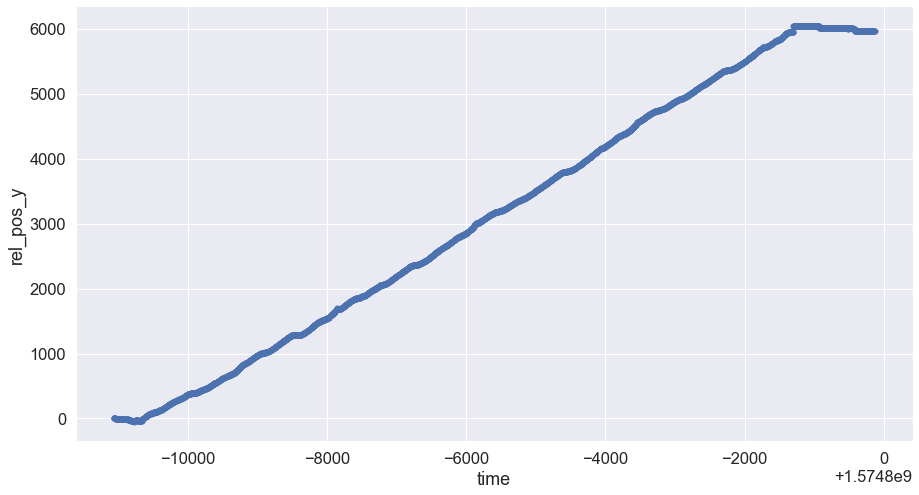

In [211]:
fig,ax=plt.subplots(figsize=(15,8))
sns.scatterplot(ts.df.time, ts.df.rel_pos_y, linewidth=0)

---
<a id='plotting'></a>
## Plotting
### A. DVL-Odometry vs. Dead-Reckoning

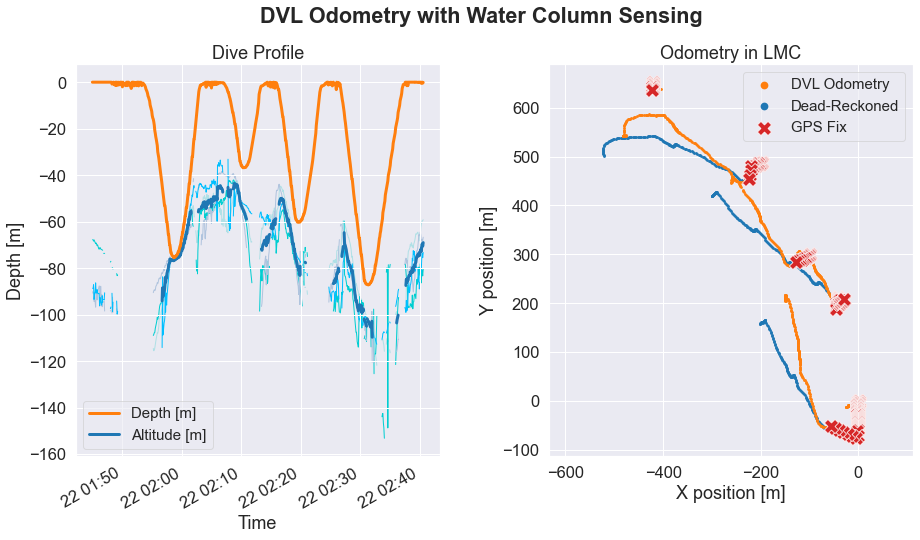

In [385]:
reload_modules()
dvl_plotter.plot_profile_and_odometry_and_dr(ts, ts_flight_kolumbo_all, save_name='tmp-profile.png')

---
### B. MF-TAN: Factor Extraction and Seafloor Maps 
*Note: this plot is not displayed in the Jupyter notebook because it is too large to be displayed quickly. Instead, the plot is saved to the specified directory.*


In [197]:
reload_modules()

# plots bathy maps with three factors extracted 
# dvl_plotter.plot_profile_and_odometry_and_dr_and_three_factors(ts, ts_flight_kolumbo_all, bathy_df, save_name='tmp-three-factor.png')

# plots bathy slope map with DVL odometry 
dvl_plotter.plot_profile_and_odometry_and_dr_and_slope_factor(ts, ts_flight_kolumbo_all, bathy_df, save_name='tmp-slope-factor.png')

---
### C. Water Column Currents

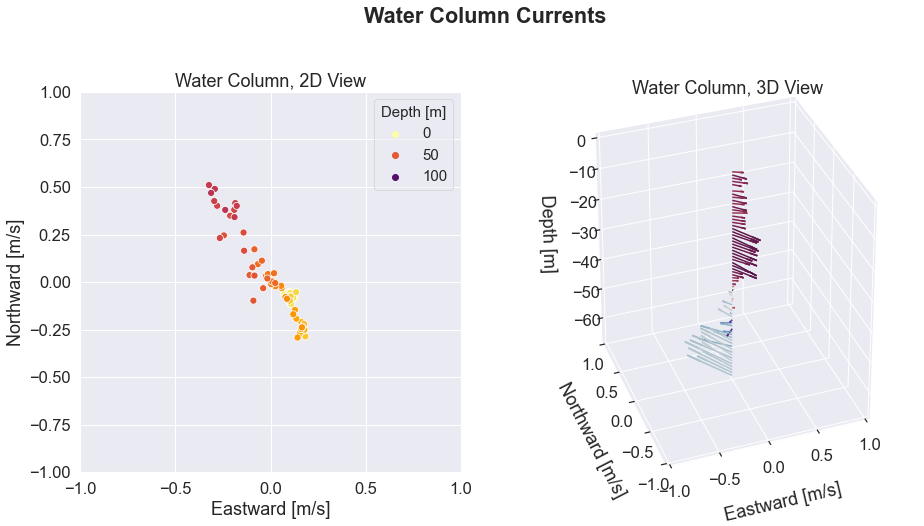

In [482]:
reload_modules()
dvl_plotter.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, voc_z_list, save_name='tmp-water-column.png')

---
### D. Exploitative Depth Band Selection (EDBS)

In [485]:
reload_modules()
dive_b_depth = 67
dive_f_depth = 97

dive_depth = dive_b_depth
arctic_depth = 80
heading_list = np.arange(0,45,45)

#################################################
# Rescale Ocean Currents + add Gyre #############
#################################################
strawman_voc_u, strawman_voc_v, strawman_voc_z = AdaptiveVelocityController.AVC.get_rescaled_voc_lists(
    dive_depth, 
    arctic_depth, 
    voc_u_list, 
    voc_v_list
)
# add gyre component to the water column
gyre_mag = 0.1
gyre_dir = 315
gyre_u   = gyre_mag*np.sin(gyre_dir*np.pi/180)
gyre_v   = gyre_mag*np.cos(gyre_dir*np.pi/180)
depth_band_voc_u = list(np.array(strawman_voc_u) + gyre_u)
depth_band_voc_v = list(np.array(strawman_voc_v) + gyre_v)


# #################################################
# # Compute the Optimal Depth Band ################
# #################################################
# for heading in heading_list:
#     P_hotel_survey          = 6.37
#     p_hotel_transit_reduced = 0.37 + 0.2 + 0.2
#     p_hotel_survey_reduced  = 0.37 + 1.75
#     max_depth = 80
#     pitch     = 5
#     p_hotel   = p_hotel_survey_reduced
#     opt_z_dive, opt_z_climb, opt_TC, dive_list, climb_list, TC_list = AdaptiveVelocityController.AVC.get_optimal_depth_band(
#         depth_band_voc_u, 
#         depth_band_voc_v, 
#         max_depth, 
#         heading,
#         pitch, 
#         p_hotel,
#         voc_interval_len=1, 
#         percent_ballast=0.2
#     )


# #################################################
# # Plotting the Optimal Depth Band ###############
# #################################################
#     dvl_plotter.plot_exploitative_depth_bands(
#         dive_list, 
#         climb_list, 
#         TC_list, 
#         heading, 
#         np.array(depth_band_voc_u),
#         np.array(depth_band_voc_v),
#         np.array([0 for _ in depth_band_voc_u]),
#         np.array(strawman_voc_z)
#     )



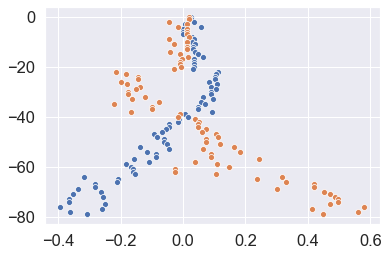

In [488]:
sns.scatterplot(depth_band_voc_u, -1*np.array(range(len(depth_band_voc_v))))
sns.scatterplot(depth_band_voc_v, -1*np.array(range(len(depth_band_voc_v))))

In [654]:
reload_modules()
strawmanAVC = AdaptiveVelocityController.AVC()
opt_listB = [(39,79), (0,77), (0,54),  (0,50), (0,61), (0,63), (0,79), (32,79)]
opt_listF = [ (0,75), (0,76), (23,79), (8,79), (0,79), (0,66), (0,63), (0,66)]
opt_list  = opt_listB
heading_list = np.arange(0,360,45)

for i in range(len(heading_list)):
# for i in range(1):
    heading = heading_list[i]
    z_c     = opt_list[i][0]
    z_d     = opt_list[i][1]
    
    speeds_EDBS = []
    speeds_WC   = []
    
    for z in range(0,80):
        factor=1
        voc_u = depth_band_voc_u[z]*factor
        voc_v = depth_band_voc_v[z]*factor
        voc_heading  = np.arctan2(voc_u, voc_v)
        voc_mag      = np.linalg.norm([voc_u, voc_v])
        voc_delta    = voc_heading - heading*strawmanAVC.DEG_TO_RAD
        
        vog = AdaptiveVelocityController.AVC.get_optimal_vog(
            voc_mag, 
            voc_delta, 
            p_hotel_survey_reduced,
            5,
            z_d,
            z_c,
            0.2
        )
        vtw_prop = AdaptiveVelocityController.AVC.get_optimal_vtw_prop(
            voc_mag, 
            voc_delta, 
            p_hotel_survey_reduced,
            5,
            z_d,
            z_c,
            0.2
        )
#         print("Depth: %2d, Mag: %0.2f, Dir: %3d,  OG: %0.2f, TW: %0.2f" % (z, voc_mag, abs(voc_delta*180/np.pi), vog, vtw_prop))
        
        
        speeds_WC.append(vog)
        if z >= z_c and z <= z_d:
            speeds_EDBS.append(vog)
            
    avg_EDBS = np.mean(speeds_EDBS)
    avg_WC   = np.mean(speeds_WC)
    imp      = 100*(avg_EDBS - avg_WC)/avg_WC
    print("heading: %3d,  WC: %0.3f, EDBS: %0.3f, Imp.: %0.3f" % (heading, avg_WC, avg_EDBS, imp))

    
    opt_TC = strawmanAVC.get_depth_band_transport_cost(
        z_dive=z_d, 
        z_climb=z_c, 
        voc_u_list=depth_band_voc_u, 
        voc_v_list=depth_band_voc_v, 
        p_hotel=p_hotel_survey_reduced,
        heading=h,
        pitch=5, 
        voc_interval_len=1,
        percent_ballast=0.2)
    reg_TC = strawmanAVC.get_depth_band_transport_cost(
        z_dive=79, 
        z_climb=0, 
        voc_u_list=depth_band_voc_u, 
        voc_v_list=depth_band_voc_v, 
        p_hotel=p_hotel_survey_reduced,
        heading=h,
        pitch=5, 
        voc_interval_len=1,
        percent_ballast=0.2)
#     print("Heading: %3d, z_c: %2d,  z_d: %2d,  Reg: %0.2f,  Opt: %0.2f,  Per: %0.2f" % (h, z_c, z_d, reg_TC, opt_TC, 100*(reg_TC-opt_TC)/opt_TC))

heading:   0,  WC: 0.735, EDBS: 0.736, Imp.: 0.050
heading:  45,  WC: 0.746, EDBS: 0.742, Imp.: -0.525
heading:  90,  WC: 0.741, EDBS: 0.714, Imp.: -3.642
heading: 135,  WC: 0.725, EDBS: 0.693, Imp.: -4.419
heading: 180,  WC: 0.728, EDBS: 0.711, Imp.: -2.356
heading: 225,  WC: 0.746, EDBS: 0.720, Imp.: -3.420
heading: 270,  WC: 0.749, EDBS: 0.749, Imp.: 0.000
heading: 315,  WC: 0.693, EDBS: 0.670, Imp.: -3.309


In [341]:
p_hotel_survey_reduced

2.12

In [509]:
# reload_modules()
# res = 100
# u_list = np.linspace(-1,1,res)
# v_list = np.linspace(-1,1,res)
# z_d = 79
# z_c = 0
# p_hotel = p_hotel_survey_reduced
# pitch = 5
# ballast = 0.2
# count = 0

# u_mat = []
# v_mat = []
# vtw_mat = []
# vog_mat = []


# for v in v_list: 
#     for u in u_list:
#         voc_delta = np.arctan2(u, v)
#         voc_mag   = np.linalg.norm([u, v])
#         vog = AdaptiveVelocityController.AVC.get_optimal_vog(voc_mag, voc_delta, p_hotel, pitch, z_d, z_c, ballast)
#         vtw = AdaptiveVelocityController.AVC.get_optimal_vtw_prop(voc_mag, voc_delta, p_hotel, pitch, z_d, z_c, ballast)
#         vtw_mat.append(vtw)
#         vog_mat.append(vog)
#         u_mat.append(u)
#         v_mat.append(v)
#     count+=1
#     print(count)

In [412]:
vog_np  = np.reshape(vog_mat,(res,res))
vog_tmp = vog_np.copy()
vog_tmp[vog_tmp >= 1.5] = 1.49

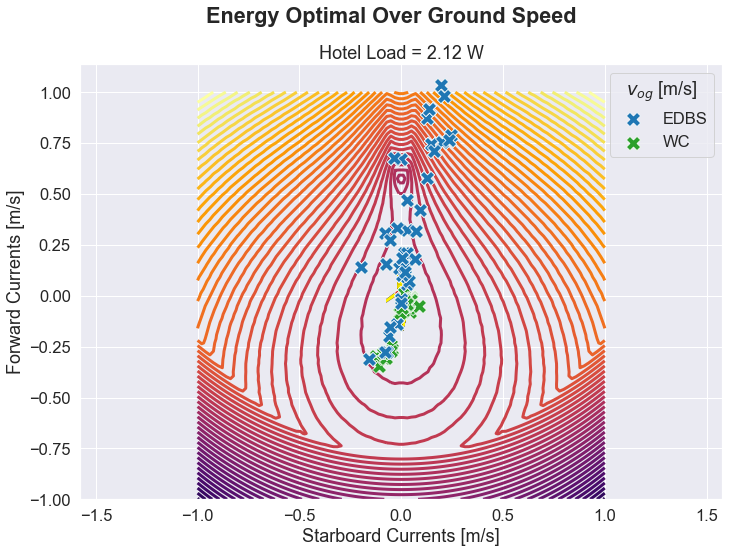

In [653]:
###### initialize plot
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(11.5,8))

# plot glider 
glider_im = Image.open('glider.png')
glider_w,glider_h = glider_im.size
glider_AR  = glider_w/glider_h
glider_len = .40
glider_wid =  glider_AR*glider_len
glider_top =  glider_len/2
glider_bot = -glider_len/2
glider_lef = -glider_wid/2
glider_rig =  glider_wid/2
ax.imshow(glider_im, extent=(glider_lef, glider_rig, glider_top, glider_bot), origin='lower', zorder=2)
# vtw_mat[200*100+100]=0
# vog_mat[200*100+100]=0
ax.axis('equal')

# # plot velocity values
# scatter=sns.scatterplot(
#     x=u_mat, 
#     y=v_mat, 
# #     hue=vtw_mat,
#     hue=vog_tmp.flatten(),
#     s=20,
#     marker='s',
#     palette='inferno',
#     linewidth=0,
# )

levels = np.linspace(0,1.5,61)
# levels   = np.array([0.711, 0.72, 0.73, 0.74, 0.75, 0.76, 0.8])
# c_levels = np.log(levels)
# c_levels = c_levels - np.min(c_levels)
# c_levels = c_levels/np.max(c_levels)
widths = [3 for _ in levels]
# widths[1] = 7
# styles = ['dashed' for _ in widths]
# styles[1] = 'solid'
colors = plt.cm.inferno(np.abs((np.array(levels)/1.5)))
# colors = plt.cm.inferno(c_levels)
# colors[0] = plt.cm.hsv(0)

CS = ax.contour(
    u_list, 
    v_list, 
    vog_np, 
    levels=levels, 
    linewidths=widths, 
#     linestyles=styles, 
#     vmin=-100, 
#     vmax=2000,
    colors=colors
)
# ax.clabel(CS, inline=1, fontsize=22, fmt='%0.2f', )

# plot center x mark
sns.scatterplot(
    x=[0], 
    y=[0], 
    marker='X',
    color='tab:red', 
    s=200,
    zorder=3,
)


i=7
heading = heading_list[i]
z_c     = opt_list[i][0]
z_d     = opt_list[i][1]

tmp_u = np.array(depth_band_voc_u)*factor
tmp_v = np.array(depth_band_voc_v)*factor
tmp_heading  = np.arctan2(tmp_u, tmp_v)
tmp_mag      = (tmp_u**2 + tmp_v**2)**0.5
tmp_delta    = tmp_heading - heading*strawmanAVC.DEG_TO_RAD

tmp_u = np.sin(tmp_delta)*tmp_mag
tmp_v = np.cos(tmp_delta)*tmp_mag


sns.scatterplot(
    x=tmp_u[z_c:z_d], 
    y=tmp_v[z_c:z_d], 
    color='tab:blue',
    marker='X',
    label='EDBS',
    s=200,
    zorder=4,
)


sns.scatterplot(
    x=tmp_u[0:79], 
    y=tmp_v[0:79], 
    color='tab:green',
    marker='X',
    label='WC',
    s=200,
    zorder=3,
)




ax.axis('equal')
plt.xlabel('Starboard Currents [m/s]')
plt.ylabel('Forward Currents [m/s]')
plt.gca().invert_yaxis()
# plt.suptitle('Energy Optimal Through Water Speed', fontweight='bold')
plt.suptitle('Energy Optimal Over Ground Speed', fontweight='bold')
plt.title('Hotel Load = %.2f W' % (p_hotel))
l_handles, l_labels = ax.get_legend_handles_labels()
# plt.legend(title='$v_{tw}$ [m/s]')
plt.legend(title='$v_{og}$ [m/s]')
plt.savefig('/Users/zduguid/Desktop/fig/tmp-%d.png'%heading)

In [643]:
for i in range(1,361):
    
    X = np.linspace(-1, 1, res)
    Y = np.linspace(-1, 1, res)
    X, Y = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(20,10))
    ax  = fig.add_subplot(121, projection='3d')
    
    surf = ax.plot_surface(X, Y, np.reshape(vtw_mat,(res,res)), cmap=plt.cm.inferno,
                           linewidth=0, antialiased=False, zorder=1, alpha=1)
    
    ax.azim =  i    # [deg]
    ax.elev =  20   # [deg]
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel('North Current [m/s]')
    ax.set_xlabel('East Current [m/s]')
    ax.set_zlabel('\n'+ r'$v_{tw}$ [m/s]')
    ax.set_title('Through Water Speed')
    ax.patch.set_facecolor('white')
    ax.w_xaxis.set_pane_color((234/255, 234/255, 242/255, 1.0))
    ax.w_yaxis.set_pane_color((234/255, 234/255, 242/255, 1.0))
    ax.w_zaxis.set_pane_color((234/255, 234/255, 242/255, 1.0))
    ax.set_zlim((0,1.5))
    
    
    ax  = fig.add_subplot(122, projection='3d')
    
    surf = ax.plot_surface(X, Y, vog_np, cmap=plt.cm.viridis,
                           linewidth=0, antialiased=False, zorder=1)
    
    ax.azim =  i    # [deg]
    ax.elev =  20   # [deg]
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel('North Current [m/s]')
    ax.set_xlabel('East Current [m/s]')
    ax.set_zlabel('\n'+ r'$v_{og}$ [m/s]')
    ax.set_title('Over Ground Speed')
    ax.patch.set_facecolor('white')
    ax.w_xaxis.set_pane_color((234/255, 234/255, 242/255, 1.0))
    ax.w_yaxis.set_pane_color((234/255, 234/255, 242/255, 1.0))
    ax.w_zaxis.set_pane_color((234/255, 234/255, 242/255, 1.0))
    ax.set_zlim((0,1.5))
        
    if i >= 0 and i < 10:     leading_zeros ='00'
    elif i >= 10 and i < 100: leading_zeros = '0'
    else:                     leading_zeros = ''
    
    plt.suptitle('Adaptive Velocity Control with 2D Ocean Currents', fontweight='bold')
    plt.savefig('/Users/zduguid/Desktop/fig/animation/vog-%s%d.png' % (leading_zeros, i))
    plt.close()
    if i%5==0:
        print('made %3d plots!'%i)

made   5 plots!
made  10 plots!
made  15 plots!
made  20 plots!
made  25 plots!
made  30 plots!
made  35 plots!
made  40 plots!
made  45 plots!
made  50 plots!
made  55 plots!
made  60 plots!
made  65 plots!
made  70 plots!
made  75 plots!
made  80 plots!
made  85 plots!
made  90 plots!
made  95 plots!
made 100 plots!
made 105 plots!
made 110 plots!
made 115 plots!
made 120 plots!
made 125 plots!
made 130 plots!
made 135 plots!
made 140 plots!
made 145 plots!
made 150 plots!
made 155 plots!
made 160 plots!
made 165 plots!
made 170 plots!
made 175 plots!
made 180 plots!
made 185 plots!
made 190 plots!
made 195 plots!
made 200 plots!
made 205 plots!
made 210 plots!
made 215 plots!
made 220 plots!
made 225 plots!
made 230 plots!
made 235 plots!
made 240 plots!
made 245 plots!
made 250 plots!
made 255 plots!
made 260 plots!
made 265 plots!
made 270 plots!
made 275 plots!
made 280 plots!
made 285 plots!
made 290 plots!
made 295 plots!
made 300 plots!
made 305 plots!
made 310 plots!
made 315

In [474]:
np.linspace(0,1.5,61)

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
       1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
       1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  ])

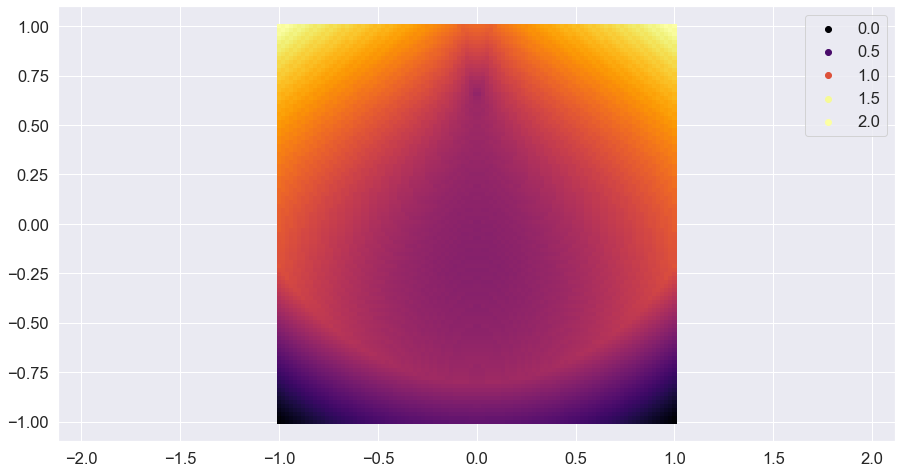

In [340]:
fig,ax = plt.subplots(figsize=(15,8))
plt.axis('equal')
sns.scatterplot(u_mat, v_mat, vog_mat, linewidth=0, s=20, marker='s', palette='inferno' )

In [333]:
np.linspace(0, 1.5, 121)

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
       0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
       0.3   , 0.3125, 0.325 , 0.3375, 0.35  , 0.3625, 0.375 , 0.3875,
       0.4   , 0.4125, 0.425 , 0.4375, 0.45  , 0.4625, 0.475 , 0.4875,
       0.5   , 0.5125, 0.525 , 0.5375, 0.55  , 0.5625, 0.575 , 0.5875,
       0.6   , 0.6125, 0.625 , 0.6375, 0.65  , 0.6625, 0.675 , 0.6875,
       0.7   , 0.7125, 0.725 , 0.7375, 0.75  , 0.7625, 0.775 , 0.7875,
       0.8   , 0.8125, 0.825 , 0.8375, 0.85  , 0.8625, 0.875 , 0.8875,
       0.9   , 0.9125, 0.925 , 0.9375, 0.95  , 0.9625, 0.975 , 0.9875,
       1.    , 1.0125, 1.025 , 1.0375, 1.05  , 1.0625, 1.075 , 1.0875,
       1.1   , 1.1125, 1.125 , 1.1375, 1.15  , 1.1625, 1.175 , 1.1875,
       1.2   , 1.2125, 1.225 , 1.2375, 1.25  , 1.2625, 1.275 , 1.2875,
       1.3   , 1.3125, 1.325 , 1.3375, 1.35  , 1.3625, 1.375 , 1.3875,
      

In [ ]:
strawmanAVC.get_vtw_buoy(pitch=5, percent_ballast=0.2)

In [ ]:
heading:   0,  WC: 0.734, EDBS: 0.734, Imp.: 0.019
heading:  45,  WC: 0.745, EDBS: 0.741, Imp.: -0.521
heading:  90,  WC: 0.740, EDBS: 0.714, Imp.: -3.607
heading: 135,  WC: 0.726, EDBS: 0.694, Imp.: -4.378
heading: 180,  WC: 0.728, EDBS: 0.712, Imp.: -2.266
heading: 225,  WC: 0.745, EDBS: 0.719, Imp.: -3.515
heading: 270,  WC: 0.748, EDBS: 0.748, Imp.: 0.000
heading: 315,  WC: 0.694, EDBS: 0.671, Imp.: -3.31

--- 
<a id='sandbox'></a>
## Sandbox
Code below this cell is experimental and may contain bugs.

In [ ]:
p_default_dvl_msis_bsd   = 2.00 + 3.00 + 0.4 # W
p_reduce_dvl_msis_bsd    = 0.64 + 0.66 + 0.2 # W
p_other_hotel            = 0.97
p_hotel_transit_with_dvl = 0.37 + 2.0  + 0.4 # W
p_hotel_transit_reduced  = 0.37 + 0.64 + 0.2 # W
p_hotel_survey           = 0.37 + 6.0        # W
p_hotel_survey_reduced   = 0.37 + p_other_hotel + p_reduce_dvl_msis_bsd

---
## Glider Range Simulator

In [ ]:
###########################################
# CONSTANTS 
# # these values are from the glider spreadsheet document 
# p_buoyancy_26deg_50m = 11.03   # Whr/km
# p_buoyancy_12deg_50m =  5.75   # Whr/km
# p_buoyancy_12deg_25m =  6.88   # Whr/km

buoyant_26deg_speed  = 0.37    # m/s
buoyant_12deg_speed  = 0.26    # m/s

p_default_dvl_msis_bsd   = 2.00 + 3.00 + 0.4 # W
p_reduce_dvl_msis_bsd    = 0.64 + 0.66 + 0.2 # W
p_other_hotel            = 0.97

p_hotel_transit_with_dvl = 0.37 + 2.0  + 0.4 # W
p_hotel_transit_reduced  = 0.37 + 0.64 + 0.2 # W
p_hotel_survey           = 0.37 + 6.0        # W
p_hotel_survey_reduced   = 0.37 + p_other_hotel + p_reduce_dvl_msis_bsd

# amount of buoyancy engine power (and speed) reduced
buoyancy_reduction       = 0.2  # value deduced after discussing with Rich 


res = 200
v_list = np.linspace(0,1.5,res)
hybrid_constant_speed_transit_vtw = get_opt_v(v_list, 0, 0, p_hotel_transit_with_dvl, energy_supply)
hybrid_constant_speed_science_vtw = get_opt_v(v_list, 0, 0, p_hotel_survey,           energy_supply)
hybrid_constant_speed_transit_pow = get_prop_power(hybrid_constant_speed_transit_vtw)
hybrid_constant_speed_science_pow = get_prop_power(hybrid_constant_speed_science_vtw)



###########################################
# CASE 1: 26 degree engine buoyancy engine 
buoyancy_26_deg_x = [0]
buoyancy_26_deg_y = [0]
buoyancy_26_deg_z = [0]
buoyancy_26_deg_t = [0]
buoyancy_26_deg_e = [0]
buoyancy_26_sci_d = 0
buoyancy_26_sci_t = 0
buoyancy_26_num_i = 0



###########################################
# CASE 2: 12 degree engine buoyancy engine 
buoyancy_12_deg_x = [0]
buoyancy_12_deg_y = [0]
buoyancy_12_deg_z = [0]
buoyancy_12_deg_t = [0]
buoyancy_12_deg_e = [0]
buoyancy_12_sci_d = 0
buoyancy_12_sci_t = 0
buoyancy_12_num_i = 0



###########################################
# CASE 3: constant hybrid speed 
hybrid_constant_x = [0]
hybrid_constant_y = [0]
hybrid_constant_z = [0]
hybrid_constant_t = [0]
hybrid_constant_e = [0]
hybrid_cons_sci_d = 0
hybrid_cons_sci_t = 0
hybrid_cons_num_i = 0



###########################################
# CASE 4: adaptive hybrid speed 
hybrid_adaptive_x = [0]
hybrid_adaptive_y = [0]
hybrid_adaptive_z = [0]
hybrid_adaptive_t = [0]
hybrid_adaptive_e = [0]
hybrid_adap_sci_d = 0
hybrid_adap_sci_t = 0
hybrid_adap_num_i = 0

hybrid_adap_vtw_d = {}
hybrid_adap_sci_vtw_d = {}
for waypoint_index in range(len(waypoints)-1):
    hybrid_adap_vtw_d[waypoint_index] = {}
    glider_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
    for z in range(arctic_depth):
        voc_u = strawman_voc_u[z]
        voc_v = strawman_voc_v[z]
        if np.isnan(voc_u):
            voc_u = 0
            voc_v = 0
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw            = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_transit_with_dvl, energy_supply)
        hybrid_adap_vtw_d[waypoint_index][z] = vtw
for i in range(4):
    glider_heading = 0 + i*(np.pi/2)
    hybrid_adap_sci_vtw_d[glider_heading] = {}
    for z in range(arctic_depth):
        gyre_u = 0.1*np.sin(315*np.pi/180)
        gyre_v = 0.1*np.cos(315*np.pi/180)
        
        voc_u = strawman_voc_u[z] + gyre_u
        voc_v = strawman_voc_v[z] + gyre_v
            
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw_sci        = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_survey*1, energy_supply)
        hybrid_adap_sci_vtw_d[glider_heading][z] = vtw_sci
        
        

###########################################
# CASE 5: reduced hotel load 
hybrid_reduce_h_x = [0]
hybrid_reduce_h_y = [0]
hybrid_reduce_h_z = [0]
hybrid_reduce_h_t = [0]
hybrid_reduce_h_e = [0]
hybrid_reduce_sci_d = 0
hybrid_reduce_sci_t = 0
hybrid_reduce_num_i = 0

hybrid_reduce_vtw_d = {}
hybrid_reduce_sci_vtw_d = {}
for waypoint_index in range(len(waypoints)-1):
    hybrid_reduce_vtw_d[waypoint_index] = {}
    glider_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
    for z in range(arctic_depth):
        voc_u = strawman_voc_u[z]
        voc_v = strawman_voc_v[z]
        if np.isnan(voc_u):
            voc_u = 0
            voc_v = 0
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw            = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_transit_reduced, energy_supply)
        hybrid_reduce_vtw_d[waypoint_index][z] = vtw
for i in range(4):
    glider_heading = 0 + i*(np.pi/2)
    hybrid_reduce_sci_vtw_d[glider_heading] = {}
    for z in range(arctic_depth):
        gyre_u = 0.1*np.sin(315*np.pi/180)
        gyre_v = 0.1*np.cos(315*np.pi/180)
        
        voc_u = strawman_voc_u[z] + gyre_u
        voc_v = strawman_voc_v[z] + gyre_v
        
        ocean_heading  = np.arctan2(voc_u, voc_v)
        ocean_mag      = np.linalg.norm([voc_u, voc_v])
        delta_heading  = ocean_heading - glider_heading
        vtw_sci        = get_opt_v(v_list, ocean_mag, delta_heading, p_hotel_survey_reduced, energy_supply)
        hybrid_reduce_sci_vtw_d[glider_heading][z] = vtw_sci


###########################################
# CASE 6: exploitative depth banding 
# 25m depth banding -- should be twice as expensive compared to others 
hybrid_depthbnd_x = [0]
hybrid_depthbnd_y = [0]
hybrid_depthbnd_z = [0]
hybrid_depthbnd_t = [0]
hybrid_depthbnd_e = [0]

hybrid_depthbnd_sci_d = 0
hybrid_depthbnd_sci_t = 0
hybrid_depthbnd_num_i = 0


compute_cases = {
    1 : True,
    2 : True, 
    3 : True,  
    4 : True, 
    5 : True, 
    6 : True, 
# }

# compute_cases = {
#     1 : False,
# #     1 : True,
#     2 : False,
# #     2 : True,
#     3 : False, 
# #     3 : True, 
#     4 : False, 
# #     4 : True, 
# #     5 : False,
#     5 : True, 
# #     6 : False,
#     6 : True, 
# }


# CASE 1 ##################################
if compute_cases[1]:
    print("> computing case 1")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (buoyancy_26_deg_x[-1], buoyancy_26_deg_y[-1])
        depth          =  buoyancy_26_deg_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(500000):
            prev_x, prev_y, prev_z = buoyancy_26_deg_x[-1], buoyancy_26_deg_y[-1], buoyancy_26_deg_z[-1]
            ocean_heading  = np.arctan2(avg_voc_u, avg_voc_v)
            delta_heading  = ocean_heading - glider_heading
            
            voc_hor        = buoyant_26deg_speed
            voc_ver        = np.tan(26*np.pi/180)*buoyant_26deg_speed*vertical_direction
            voc_para       = avg_voc_mag*np.cos(delta_heading)
            voc_perp       = avg_voc_mag*np.sin(delta_heading)
            vtw_para       = (voc_hor**2 - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*voc_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z 
            delta_e        = (delta_t/3600) * p_hotel_transit_with_dvl
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                buoyancy_26_num_i  +=  1
                buoyancy_26_deg_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
                
            # updates lists 
            buoyancy_26_deg_x.append(new_x)
            buoyancy_26_deg_y.append(new_y)
            buoyancy_26_deg_z.append(new_z)
            buoyancy_26_deg_t.append(delta_t)
            buoyancy_26_deg_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
        

# CASE 2 ##################################
if compute_cases[2]:
    print("> computing case 2")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (buoyancy_12_deg_x[-1], buoyancy_12_deg_y[-1])
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(500000):
            prev_x, prev_y, prev_z = buoyancy_12_deg_x[-1], buoyancy_12_deg_y[-1], buoyancy_12_deg_z[-1]
            ocean_heading  = np.arctan2(avg_voc_u, avg_voc_v)
            delta_heading  = ocean_heading - glider_heading
            
            voc_hor        = buoyant_12deg_speed
            voc_ver        = np.tan(12*np.pi/180)*buoyant_12deg_speed*vertical_direction
            voc_para       = avg_voc_mag*np.cos(delta_heading)
            voc_perp       = avg_voc_mag*np.sin(delta_heading)
            vtw_para       = (voc_hor**2 - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*voc_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            delta_e        = (delta_t/3600) * p_hotel_transit_with_dvl 
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                buoyancy_12_num_i  +=  1
                buoyancy_12_deg_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
                
            # updates lists 
            buoyancy_12_deg_x.append(new_x)
            buoyancy_12_deg_y.append(new_y)
            buoyancy_12_deg_z.append(new_z)
            buoyancy_12_deg_t.append(delta_t)
            buoyancy_12_deg_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(buoyancy_12_deg_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)

            ocean_heading  = np.arctan2(avg_voc_u+gyre_u, avg_voc_v+gyre_v)
            ocean_mag      = np.linalg.norm([avg_voc_u+gyre_u, avg_voc_v+gyre_v])
            delta_heading  = ocean_heading - glider_heading 

            vtw_hor        = buoyant_12deg_speed
            vtw_ver        = buoyant_12deg_speed*np.tan(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            buoyancy_12_sci_d +=  delta_dist
            buoyancy_12_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                buoyancy_12_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
            
        
        
# CASE 3 ##################################
if compute_cases[3]:
    print("> computing case 3")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_constant_x[-1], hybrid_constant_y[-1])
        curr_depth     =  hybrid_constant_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_constant_x[-1], hybrid_constant_y[-1], hybrid_constant_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_constant_speed_transit_vtw    
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction            
            
            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            p_total        = p_hotel_transit_with_dvl + hybrid_constant_speed_transit_pow
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction *= -1
                hybrid_cons_num_i  +=  1
                hybrid_constant_e.append(2.95)
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_constant_x.append(new_x)
            hybrid_constant_y.append(new_y)
            hybrid_constant_z.append(new_z)
            hybrid_constant_t.append(delta_t)
            hybrid_constant_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(hybrid_constant_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_constant_speed_science_vtw    
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_cons_sci_d +=  delta_dist
            hybrid_cons_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_cons_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            
# CASE 4 ##################################
if compute_cases[4]:
    print("> computing case 4")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 12
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_adaptive_x[-1], hybrid_adaptive_y[-1])
        curr_depth     =  hybrid_adaptive_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_adaptive_x[-1], hybrid_adaptive_y[-1], hybrid_adaptive_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_adap_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            p_total        = p_hotel_transit_with_dvl + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                hybrid_adaptive_e.append(2.95)
                hybrid_adap_num_i  +=  1
                vertical_direction *= -1
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_adaptive_x.append(new_x)
            hybrid_adaptive_y.append(new_y)
            hybrid_adaptive_z.append(new_z)
            hybrid_adaptive_t.append(delta_t)
            hybrid_adaptive_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
            
    # perform science
    science_energy = energy_supply - sum(hybrid_adaptive_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_adap_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(12*np.pi/180)
            vtw_ver        = vtw*np.sin(12*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_adap_sci_d +=  delta_dist
            hybrid_adap_sci_t +=  delta_t
            science_energy    += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_adap_num_i   +=  1
                science_energy      += -2.95
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            
# CASE 5 ##################################
if compute_cases[5]:
    print("> computing case 5")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 5
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position  = (hybrid_reduce_h_x[-1], hybrid_reduce_h_y[-1])
        curr_depth     =  hybrid_reduce_h_z[-1]
        next_waypoint  = waypoints[waypoint_index+1]
        glider_heading = get_heading(curr_position, next_waypoint)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_reduce_h_x[-1], hybrid_reduce_h_y[-1], hybrid_reduce_h_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_reduce_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            # TODO
            p_total        = p_hotel_transit_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            
            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                hybrid_reduce_h_e.append(2.95*buoyancy_reduction)
                hybrid_reduce_num_i +=  1
                vertical_direction  *= -1
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1

            # updates lists 
            hybrid_reduce_h_x.append(new_x)
            hybrid_reduce_h_y.append(new_y)
            hybrid_reduce_h_z.append(new_z)
            hybrid_reduce_h_t.append(delta_t)
            hybrid_reduce_h_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
    
    # perform science
    science_energy = energy_supply - sum(hybrid_reduce_h_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_reduce_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_reduce_sci_d +=  delta_dist
            hybrid_reduce_sci_t +=  delta_t
            science_energy      += -delta_e

            if new_z > arctic_depth-1:
                new_z = arctic_depth-1
                vertical_direction  *= -1
                hybrid_reduce_num_i +=  1
                science_energy      += -2.95*buoyancy_reduction
            elif new_z < 0:
                new_z = 0
                vertical_direction *= -1
            
            
# CASE 6 ##################################
if compute_cases[6]:
    print("> computing case 6")
    waypoint_capture   = 10 # m
    vertical_direction = 1
    glider_pitch       = 5
    for waypoint_index in range(len(waypoints)-1):

        flag_hit_waypoint = False
        curr_position    = (hybrid_depthbnd_x[-1], hybrid_depthbnd_y[-1])
        curr_depth       =  hybrid_depthbnd_z[-1]
        next_waypoint    = waypoints[waypoint_index+1]
        glider_heading   = get_heading(curr_position, next_waypoint)
        waypoint_heading = get_heading(waypoints[waypoint_index], waypoints[waypoint_index+1])
        
        # result of optimal depth band algorithm 
        epsilon     = 0.0001
        z_climb     = 0
        z_dive      = len(strawman_voc_u)-1
        if   abs(waypoint_heading - (-0.06334)) < epsilon:
            z_climb = 39
            z_dive  = 79
        elif abs(waypoint_heading - (-0.16272)) < epsilon:
            z_climb = 43
            z_dive  = 79
        elif abs(waypoint_heading - ( 2.97886)) < epsilon:
            z_climb = 0
            z_dive  = 50
        elif abs(waypoint_heading - ( 3.07825)) < epsilon:
            z_climb = 0
            z_dive  = 61
        # 0 -0.06334   transit: (39,79)  survey: (43,79)
        # 1 -0.16272   transit: (43,79)  survey: (45,79)
        # 2  2.97886   transit: (0,50)   survey: (0, 45)
        # 3  3.07825   transit: (0,61)   survey: (0, 48)

        # iterate until next waypoint is hit 
        for t in range(200000):
            prev_x, prev_y, prev_z = hybrid_depthbnd_x[-1], hybrid_depthbnd_y[-1], hybrid_depthbnd_z[-1]
            voc_u = strawman_voc_u[int(prev_z)]
            voc_v = strawman_voc_v[int(prev_z)]
            if np.isnan(voc_u):
                voc_u = 0
                voc_v = 0
            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading
            
            vtw            = hybrid_reduce_vtw_d[waypoint_index][int(prev_z)]
            
            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_t        = 10
            delta_dist     = vog_para*delta_t
            delta_x        = delta_dist*np.sin(glider_heading)
            delta_y        = delta_dist*np.cos(glider_heading)
            delta_z        = delta_t*vtw_ver
            new_x          = prev_x+delta_x
            new_y          = prev_y+delta_y
            new_z          = prev_z+delta_z

            # convert total power in W to Whrs
            # TODO
            p_total        = p_hotel_transit_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total
            

            half_depth    = int(arctic_depth/2)
            overlap       = 10
            if new_z > z_dive:
                new_z = z_dive
                hybrid_depthbnd_e.append(2.95*buoyancy_reduction)
                hybrid_depthbnd_num_i +=  1
                vertical_direction    *= -1
            elif new_z < z_climb:
                new_z = z_climb
                vertical_direction *= -1

            # updates lists 
            hybrid_depthbnd_x.append(new_x)
            hybrid_depthbnd_y.append(new_y)
            hybrid_depthbnd_z.append(new_z)
            hybrid_depthbnd_t.append(delta_t)
            hybrid_depthbnd_e.append(delta_e)

            # check if glider made it to the waypoint
            if get_distance((new_x,new_y), next_waypoint) < waypoint_capture:
                flag_hit_waypoint = True
                break

        if not flag_hit_waypoint:
            print("  WARNING: missed a waypoint")
    
    # perform science
    science_energy = energy_supply - sum(hybrid_depthbnd_e)
    glider_heading = 0
    new_z = 0
    vertical_direction = 1
    print("  computing science statistics")
    while science_energy > 0:
        glider_heading += np.pi/2
        glider_heading  = glider_heading % (2*np.pi)
        
        z_dive  = len(strawman_voc_u) - 1
        z_climb = 0
        epsilon = 0.0001
        if   abs(glider_heading - 0.00000) < epsilon:
            z_climb = 39
            z_dive  = 79
        elif abs(glider_heading - 1.57079) < epsilon:
            z_climb = 0 
            z_dive  = 52
        elif abs(glider_heading - 3.14159) < epsilon:
            z_climb = 0
            z_dive  = 48
        elif abs(glider_heading - 4.71238) < epsilon:
            z_climb = 37
            z_dive  = 79
        
        for _ in range(160):
            prev_z   = new_z
            gyre_u   = 0.1*np.sin(315*np.pi/180)
            gyre_v   = 0.1*np.cos(315*np.pi/180)
            voc_u    = strawman_voc_u[int(prev_z)] + gyre_u
            voc_v    = strawman_voc_v[int(prev_z)] + gyre_v

            ocean_heading  = np.arctan2(voc_u, voc_v)
            ocean_mag      = np.linalg.norm([voc_u, voc_v])
            delta_heading  = ocean_heading - glider_heading

            vtw            = hybrid_reduce_sci_vtw_d[glider_heading][int(prev_z)]

            vtw_hor        = vtw*np.cos(glider_pitch*np.pi/180)
            vtw_ver        = vtw*np.sin(glider_pitch*np.pi/180)*vertical_direction

            voc_para       = ocean_mag*np.cos(delta_heading)
            voc_perp       = ocean_mag*np.sin(delta_heading)
            vtw_para       = (vtw_hor**2  - voc_perp**2)**0.5
            vog_para       = (vtw_para + voc_para)

            delta_dist     = 10
            delta_t        = delta_dist/vog_para
            p_total        = p_hotel_survey_reduced + get_prop_power(vtw)
            delta_e        = (delta_t/3600) * p_total

            delta_z        = delta_t*vtw_ver
            new_z          = prev_z+delta_z

            hybrid_depthbnd_sci_d +=  delta_dist
            hybrid_depthbnd_sci_t +=  delta_t
            science_energy        += -delta_e

            if new_z > z_dive:
                new_z = z_dive
                vertical_direction    *= -1
                hybrid_depthbnd_num_i +=  1
                science_energy        += -2.95*buoyancy_reduction
            elif new_z < z_climb:
                new_z = z_climb
                vertical_direction *= -1
            


distance_traveled_26 = \
    sum([get_distance((buoyancy_26_deg_x[i],  buoyancy_26_deg_y[i]), 
                      (buoyancy_26_deg_x[i+1],buoyancy_26_deg_y[i+1]))
        for i in range(len(buoyancy_26_deg_x)-1)])

distance_traveled_12 = \
    sum([get_distance((buoyancy_12_deg_x[i],  buoyancy_12_deg_y[i]), 
                      (buoyancy_12_deg_x[i+1],buoyancy_12_deg_y[i+1]))
        for i in range(len(buoyancy_12_deg_x)-1)])

distance_traveled_constant_thrust = \
    sum([get_distance((hybrid_constant_x[i],  hybrid_constant_y[i]), 
                      (hybrid_constant_x[i+1],hybrid_constant_y[i+1]))
        for i in range(len(hybrid_constant_x)-1)])

distance_traveled_adaptive_thrust = \
    sum([get_distance((hybrid_adaptive_x[i],  hybrid_adaptive_y[i]), 
                      (hybrid_adaptive_x[i+1],hybrid_adaptive_y[i+1]))
        for i in range(len(hybrid_adaptive_x)-1)])

distance_traveled_reduced_hotel = \
    sum([get_distance((hybrid_reduce_h_x[i],  hybrid_reduce_h_y[i]), 
                      (hybrid_reduce_h_x[i+1],hybrid_reduce_h_y[i+1]))
        for i in range(len(hybrid_reduce_h_x)-1)])

distance_traveled_depth_band = \
    sum([get_distance((hybrid_depthbnd_x[i],  hybrid_depthbnd_y[i]), 
                      (hybrid_depthbnd_x[i+1],hybrid_depthbnd_y[i+1]))
        for i in range(len(hybrid_depthbnd_x)-1)])

print()
if compute_cases[1]:
    print('- 1. Buoyancy Driven at 26 deg ------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_26/1000))
    print('      transit time: %f [day]'  % (sum(buoyancy_26_deg_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(buoyancy_26_deg_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(buoyancy_26_deg_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (buoyancy_26_sci_d/1000))
    print('      science time: %f [day]'  % (buoyancy_26_sci_t/60/60/24))
    print('      # inflection: %d'        % (buoyancy_26_num_i))
    print('       improvement: %f'        % (0))
    print()

if compute_cases[2]:
    print('- 2. Buoyancy Driven at 12 deg ------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_12/1000))
    print('      transit time: %f [day]'  % (sum(buoyancy_12_deg_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(buoyancy_12_deg_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(buoyancy_12_deg_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (buoyancy_12_sci_d/1000))
    print('      science time: %f [day]'  % (buoyancy_12_sci_t/60/60/24))
    print('      # inflection: %d'        % (buoyancy_12_num_i))
    print('       improvement: %f'        % ((buoyancy_12_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[3]:
    print('- 3. Hybrid Constant Speed ----------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_constant_thrust/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_constant_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_constant_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_constant_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_cons_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_cons_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_cons_num_i))
    print('       improvement: %f'        % ((hybrid_cons_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[4]:
    print('- 4. Hybrid Adaptive Speed ----------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_adaptive_thrust/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_adaptive_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_adaptive_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_adaptive_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_adap_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_adap_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_adap_num_i))
    print('       improvement: %f'        % ((hybrid_adap_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    
if compute_cases[5]:
    print('- 5. Reduced Hotel Load -------------------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_reduced_hotel/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_reduce_h_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_reduce_h_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_reduce_h_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_reduce_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_reduce_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_reduce_num_i))
    print('       improvement: %f'        % ((hybrid_reduce_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()
    

if compute_cases[6]:
    print('- 6. Exploitative Depth Banding -----------------------')
    print('      transit dist: %f [km]'   % (distance_traveled_depth_band/1000) )
    print('      transit time: %f [day]'  % (sum(hybrid_depthbnd_t)/60/60/24))
    print('      transit ener: %f [kWhr]' % (sum(hybrid_depthbnd_e)/1000))
    print('      transit econ: %f [J/m]'  % (sum(hybrid_depthbnd_e)*3600/strawman_range))
    print('      science dist: %f [km]'   % (hybrid_depthbnd_sci_d/1000))
    print('      science time: %f [day]'  % (hybrid_depthbnd_sci_t/60/60/24))
    print('      # inflection: %d'        % (hybrid_depthbnd_num_i))
    print('       improvement: %f'        % ((hybrid_depthbnd_sci_d+strawman_range-baseline_range)/baseline_range*100))
    print()

---
## Helper Function for Extracting Navigation Performance

In [ ]:
# # code for selecting portion of vehicle flight data that matches current file
# # select portion of dbd time series to get timestamp of gps fix
# start  = datetime.datetime.fromtimestamp(ts.df.time[0])
# end    = datetime.datetime.fromtimestamp(ts.df.time[-1])
# dur    = end - start 
# df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()
last_time_before_gps = 1574798703.95676

# find odometry position before updating to GPS fix
# for t in range(len(ts.df)):
#     if abs(ts.df.time[t] - last_time_before_gps) < 30:
#         print(ts.df.time[t], ts.df.rel_pos_x[t],  ts.df.rel_pos_y[t])

# (odo_x, odo_y) = ( 324.7468257010907, 5979.711680213435)
(odo_x, odo_y) = ( 294.012344218872,  5958.7493809050575)
( dr_x,  dr_y) = (-112.333,           5752.65)
(gps_x, gps_y) = ( 549.703,           6038.14)

dist_traveled  = np.linalg.norm([gps_x,         gps_y])
dist_error_dr  = np.linalg.norm([gps_x - dr_x,  gps_y - dr_y])
dist_error_odo = np.linalg.norm([gps_x - odo_x, gps_y - odo_y])

# print(dist_traveled)
# print(dist_error_dr,  (dist_error_dr/dist_traveled)*100)
# print(dist_error_odo, (dist_error_odo/dist_traveled)*100)

# results from Dive 14! (Dive A in Frontiers paper)
# 6063.110426819638
#  720.9689351116318  11.891073794771886
#  267.7322951271691   4.4157581881220365

# results from Dive 12 (Dive B in Frontiers paper)
diveb_time = [1574502907.35751, 1574508757.9585]
diveb_gpsx = [ 361.98,    221.006]
diveb_gpsy = [-1301.3,   -353.395]
diveb_DRx  = [  166.97,   201.319]
diveb_DRy  = [ -428.0,   -712.054]
diveb_DVLx = [  461.83,   182.55]
diveb_DVLy = [-1681.30,  -330.89]

# RESULTS 
#     DR error
#       51.864548 +- 14.382817 

#     DVL error
#       16.868937 +- 12.219482 


# results from Dive 2 (Dive C in Frontiers paper)
# + expect 11 surfacings that can compare GPS to DR and DVL
divec_time = [1574374232.0589,  # 1
              1574375200.6207,  # 2
              1574376070.8188,  # 3
              1574377014.1999,  # 4 
              1574377966.4793,  # 5 
              1574381916.3133,  # 6
              1574383765.3933,  # 7 
              1574384712.4462,  # 8
              1574385637.6738,  # 9
              1574386427.5504,  # 10
             ]
divec_gpsx = [  67.45, 155.88,  234.83,  309.02,  387.53,  800.65,  896.89,  972.09,  865.69, 637.73]
divec_gpsy = [ 273.50, 660.13, 1047.93, 1403.63, 1739.38, 2758.70, 2239.16, 1776.28, 1311.49, 916.25]
divec_DRx  = [-110.59, -21.79,   73.73,  159.80,  264.50,  730.05,  676.37,  795.19,  754.63, 574.68]
divec_DRy  = [-215.20,  60.53,  572.89,  922.23, 1313.70, 2012.70, 2046.05, 1643.24, 1182.25, 771.49]
divec_DVLx = [ 118.12, 188.42,  260.63,  341.29,  416.37, 1017.49,  838.03,  929.14,  866.17, 659.15]
divec_DVLy = [ 420.87, 685.96, 1139.90, 1508.59, 1855.72, 2830.07, 2257.37, 1866.80, 1385.30, 941.36]

# RESULTS
#     DR error
#       97.742942 +- 52.590832 

#     DVL error
#       23.141117 +- 13.544520 

In [ ]:
DR_per_error  = []
DVL_per_error = []

prev_gps_x = 0
prev_gps_y = 0 

for t in range(len(divec_time)):
    cur_gps_x     = divec_gpsx[t]
    cur_gps_y     = divec_gpsy[t]
    dist_traveled = get_distance((prev_gps_x,    prev_gps_y),    (cur_gps_x, cur_gps_y))
    DR_error      = get_distance((divec_DRx[t],  divec_DRy[t]),  (cur_gps_x, cur_gps_y))
    DVL_error     = get_distance((divec_DVLx[t], divec_DVLy[t]), (cur_gps_x, cur_gps_y))
    prev_gps_x, prev_gps_y = cur_gps_x, cur_gps_y
    
    DR_per_error.append(DR_error/dist_traveled * 100)
    DVL_per_error.append(DVL_error/dist_traveled * 100)

print('DR error')
print('  %f +- %f ' % (np.mean(DR_per_error), np.std(DR_per_error)))
print()
print('DVL error')
print('  %f +- %f ' % (np.mean(DVL_per_error), np.std(DVL_per_error)))

In [ ]:
start  = datetime.datetime.fromtimestamp(tsc.df.time[0])
end    = datetime.datetime.fromtimestamp(tsc.df.time[-1])
dur    = end - start 
df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()

# for gps_time in divec_time:
#     print(gps_time)
#     for t in range(len(tsc.df)):
#         cur_t = tsc.df.time[t]
#         if abs(cur_t - gps_time) < 20:
#             print(t, tsc.df.rel_pos_x[t], tsc.df.rel_pos_y[t])
        
# for t in range(len(df_dbd)):
#     print(t, df_dbd.time[t], df_dbd.m_gps_x_lmc[t], df_dbd.m_gps_y_lmc[t], df_dbd.m_x_lmc[t], df_dbd.m_y_lmc[t])

---
## Combine DVL data with Flight Controller and convert to UTM

In [ ]:
reload_modules()
SAVE = False
PLOT = True
glider      = "sentinel"
directory   = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-parsed/%s/" % glider
file_list   = [f for f in listdir(directory) if 
               isfile(join(directory,f)) and f.split('.')[-1] == 'CSV' and 
               len(f.split('_odometry')) != 2]

def get_utm_coords_from_glider_lat_lon(m_lat, m_lon): 
    """TODO
    """
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)

def get_utm_coords_from_bathy_lat_lon(lat, lon): 
    """TODO
    """
    utm_pos  = utm.from_latlon(lat, lon)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)


# build dataframes for each odometry category 
dr_list  = []
odo_list = []
gps_list = []
wpt_list = []
all_list = []

# iterate through each dbd file and 
for f in file_list:
    SECS_IN_HOUR = 60*60
    SECS_IN_MIN  = 60
    df_pd0 = pd.read_csv(directory+f, header=0, index_col=0, parse_dates=True)
    start  = datetime.datetime.fromtimestamp(df_pd0.time[0])
    end    = datetime.datetime.fromtimestamp(df_pd0.time[-1])
    dur    = end - start 
    
    # sub-select a portion of glider flight computer variables
    df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()
    print(f, "-------------------------")
    
    # extract first lat/lon gps position to use as origin
    for lat in df_dbd.m_gps_lat:
        if not np.isnan(lat):
            origin_m_lat = lat
            break
    origin_index = list(df_dbd.m_gps_lat).index(origin_m_lat)
    origin_m_lon = df_dbd.m_gps_lon[origin_index]
    origin_time  = datetime.datetime.fromtimestamp(df_dbd.time[origin_index])
    origin_hash  = df_dbd.m_filename_hash[origin_index]

    # convert to lat/lon coordinates to decimal fromat 
    origin_east,origin_north,origin_zone = get_utm_coords(origin_m_lat,origin_m_lon)
    
    # account for case when multiple dbd files span a single pd0 file
    print("    # dbd ensembles:  %d" % len(df_dbd))
    print("        # dbd files:  %d" % len(set(df_dbd.m_filename_hash)))
    print("         # missions:  %d" % len(set(df_dbd.m_mission_hash)))
    print("   input <lat, lon>: <%.2f, %.2f>" % (origin_m_lat, origin_m_lon))
    print("     UTM <  E,   N>: <%.2f, %.2f, zone=%d>\n\n" % (origin_east, origin_north, origin_zone))
    
    # extract positional offsets for the same moment in time
    sg2_x_offset = df_dbd[origin_time:].m_x_lmc[0]
    sg2_y_offset = df_dbd[origin_time:].m_y_lmc[0]
    dvl_x_offset = df_pd0[origin_time:].rel_pos_x[0]
    dvl_y_offset = df_pd0[origin_time:].rel_pos_y[0]

    # account for offsets in Glider and DVL file
    # TODO make this more SFB
    utm_dr_x  = df_dbd.m_x_lmc     - sg2_x_offset + origin_east
    utm_dr_y  = df_dbd.m_y_lmc     - sg2_y_offset + origin_north
    utm_dr_z  = df_dbd.m_depth 
    utm_gps_x = df_dbd.m_gps_x_lmc - sg2_x_offset + origin_east
    utm_gps_y = df_dbd.m_gps_y_lmc - sg2_y_offset + origin_north
    utm_wpt_x = df_dbd.c_wpt_x_lmc - sg2_x_offset + origin_east 
    utm_wpt_y = df_dbd.c_wpt_y_lmc - sg2_y_offset + origin_north 
    utm_odo_x = df_pd0.rel_pos_x   - dvl_x_offset + origin_east
    utm_odo_y = df_pd0.rel_pos_y   - dvl_y_offset + origin_north 
    utm_odo_z = df_pd0.rel_pos_z

    # collect data into indvidual DataFrames
    df_seg_dr = pd.DataFrame({
        'utm_dr_x' : utm_dr_x,
        'utm_dr_y' : utm_dr_y,
        'utm_dr_z' : utm_dr_z,
    })
    df_seg_gps = pd.DataFrame({
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
    })
    df_seg_odo = pd.DataFrame({
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,
    })
    df_seg_wpt = pd.DataFrame({
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
    })
    
    # add dataframes to running list 
    dr_list.append(df_seg_dr)
    odo_list.append(df_seg_odo)
    gps_list.append(df_seg_gps)
    wpt_list.append(df_seg_wpt)

    # convert data to pandas DataFrame
    frames = {
        'utm_dr_x'  : utm_dr_x,
        'utm_dr_y'  : utm_dr_y,
        'utm_dr_z'  : utm_dr_z,
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,    
    }
    df_all = pd.DataFrame(frames)
    all_list.append(df_all)
    
    # generate plots
    if PLOT:
        dvl_plotter.plot_odometry_and_dr_utm(df_all, glider, '/Users/zduguid/Desktop/fig/%s.png' % f.split('.')[0])
    if SAVE:
        df_odo.to_csv('/Users/zduguid/Desktop/fig/%s.csv' % f.split('.')[0])

In [ ]:
# # COMBINE FILES 
# df_dr_all  = pd.concat(dr_list)
# df_odo_all = pd.concat(odo_list)
# df_gps_all = pd.concat(gps_list)
# df_wpt_all = pd.concat(wpt_list)
# df_all_all = pd.concat(all_list)

# # PLOTTING
# sns.scatterplot(df_dr_all.utm_dr_x, df_dr_all.utm_dr_y)
# sns.scatterplot(df_wpt_all.utm_wpt_x, df_wpt_all.utm_wpt_y)
# sns.scatterplot(df_gps_all.utm_gps_x, df_gps_all.utm_gps_y)
# sns.scatterplot(df_odo_all.utm_odo_x, df_odo_all.utm_odo_y)

# # SAVING
# df_dr_all.to_csv('/Users/zduguid/Downloads/dr_all.csv')
# df_odo_all.to_csv('/Users/zduguid/Downloads/df_odo_all.csv')
# df_gps_all.to_csv('/Users/zduguid/Downloads/df_gps_all.csv')
# df_wpt_all.to_csv('/Users/zduguid/Downloads/df_wpt_all.csv')
# df_all_all.to_csv('/Users/zduguid/Downloads/all_fields_all_dives.csv')

---
<a id='unit-testing'></a>
## Unit Testing

### Velocity Shear Propagation

In [172]:
%run -i '~/Documents/Arctic-NNA/software/dvl-nav/test_VSP.py'

test_back_propagation_ascending (__main__.TestOceanCurrentPropagation) ... ok
test_back_propagation_descending (__main__.TestOceanCurrentPropagation) ... ok
test_bad_ocean_current_format (__main__.TestOceanCurrentPropagation) ... ok
test_bin_filter (__main__.TestOceanCurrentPropagation) ... ok
test_forward_propagation_ascending (__main__.TestOceanCurrentPropagation) ... ok
test_forward_propagation_descending (__main__.TestOceanCurrentPropagation) ... ok
test_one_observation (__main__.TestOceanCurrentPropagation) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.023s

OK
